# Installs

graphviz tool allows us to easily create visualizations of graphs

In [1]:
%pip install graphviz

# Imports

In [63]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from graphviz import Digraph

%matplotlib inline

# Utils

In [64]:
def trace(root):
    """Traverse a computation graph from root, returning all nodes and edges."""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """Generate a Graphviz visualization of a computation graph, displaying each node's data value."""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.data:.4f}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

def draw_dotV2(root):
    """V2: Adds node label display alongside data value."""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

def draw_dotV3(root):
    """V3: Adds gradient value display alongside label and data."""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

Neural Networks will have massive mathematical expressions so we are going to build a data structure `Value` that let's us keep track of the operations and that will help us propagate the gradients throughout a mathematical expression.

# Initialization

Neural Networks will have massive mathematical expressions so we are going to build a data structure `Value` that let's us keep track of the operations and that will help us propagate the gradients throughout a mathematical expression.


Goal: We want to build the computational graph of any expression

In [65]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"

In [66]:
a = Value(3)

In [67]:
a

Value(3)

We want to be able to perform simple operations like addition

In [68]:
b = Value(4)

try:
    a + b
except:
    print('Oops, not implemented yet')

Oops, not implemented yet


We define python's addition between objects of our class `Value` by implementing the method `__add__`

In [69]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: "Value"):
        return Value(self.data + other.data)

In [70]:
a = Value(3)
b = Value(4)

a + b #a.__add__(b)

Value(7)

yay!

# Exercise 1

Go [here](https://colab.research.google.com/github/samsung-ai-course/6-7-edition/blob/main/Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/Exercise%201%20-%20Implement%20remaining%20operators.ipynb) to jump into exercise 1.

![](https://github.com/samsung-ai-course/8th-9th-edition/blob/main/Chapter%206%20-%20Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/media/jump.jpg?raw=1)

In [71]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: "Value"):
        return Value(self.data + other.data)

    def __mul__(self, other: "Value"):
        return Value(self.data * other.data)

    def __truediv__(self, other: "Value"):
        return Value(self.data / other.data)

    def __sub__(self, other: "Value"):
        return Value(self.data - other.data)


---

Let's go back to our simple expression from last class:
$d = a*b + c$

In [72]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(4.0)

What we are missing:
> A connection between these expressions that allows us to understand "what `Values` produced these other `Values`"



`Demonstration`: track children nodes

In [73]:
class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._op = _op
        self._prev = set(_children)

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other),'+')

    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')

    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')

In [74]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(4.0)

In [75]:
list(d._prev)

[Value(-6.0), Value(10.0)]

In [76]:
a._prev

set()

Now we need a way to visualize these expressions

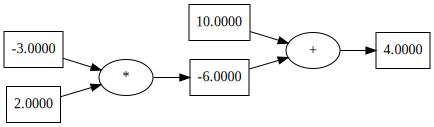

In [77]:
draw_dot(d)

Let's add labels!

In [78]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.label}| {self.data})"

    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')

    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')

    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(d| 4.0)

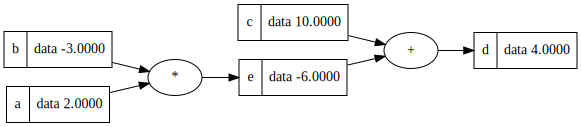

In [79]:
draw_dotV2(d)

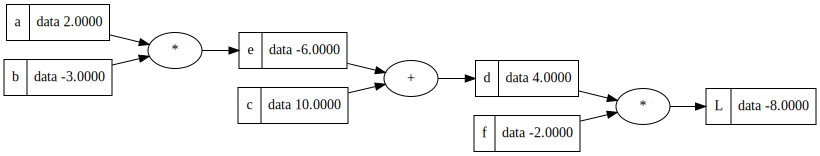

In [80]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dotV2(L)

- We've got the mathematical expression that produces the single output `L` (forward pass)
- Now we want to do backpropagation: start at the end and compute partial derivatives until we reach the leaf nodes

In NNs we are interested in derivatives of `L` wrt. particular leaf nodes (the model parameters). So each node should store it's derivative wrt. `L`

## Storing gradients

We will create a variable that stores the gradient of L wrt. to the Value object at hand

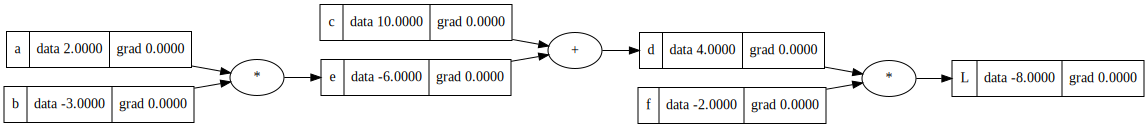

In [81]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')

    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')

    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dotV3(L)

Let's start filling the gradients $\frac{dL}{d\text{node}}$ for all nodes starting from the `L` node

> How much does L change when we change L?

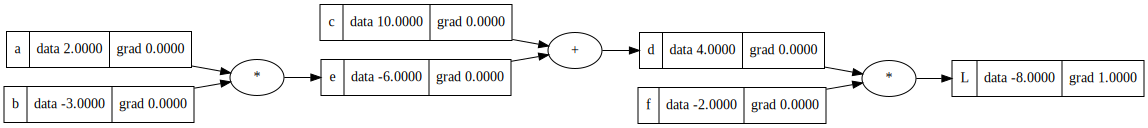

In [82]:
L.grad = 1.0
draw_dotV3(L)

Now let's continue the backpropagation:

1. $\frac{dL}{d\text{d}} = \frac{dL}{d\text{L}} \cdot \frac{dL}{d\text{d}}$

2. $\frac{dL}{df} = \frac{dL}{d\text{L}} \cdot \frac{dL}{d\text{f}}$

In [83]:
# set manually
d.grad = f.data * L.grad
f.grad = d.data * L.grad

Aaaand we continue:

1. $\frac{dL}{d\text{e}} = \frac{dL}{d\text{d}} \cdot \frac{dd}{d\text{e}}$

2. $\frac{dL}{dc} = \frac{dL}{d\text{d}} \cdot \frac{dd}{d\text{c}}$

In [84]:
# set manually
e.grad = 1 + d.grad
c.grad = 1 + d.grad

## Exercise: fill out the remaining gradients

1. $\frac{dL}{da}$

2. $\frac{dL}{db}$

In [85]:
# Exercise
a.grad = b.data * e.grad
b.grad = a.data * e.grad

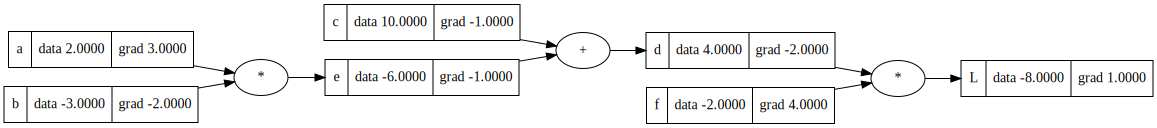

In [86]:
draw_dotV3(L)

----

Here's what've we've done manually:
1. Started from the output node
2. compute partial derivatives to the child nodes
3. do this recursively until we reach the leaf nodes
4. accumulate all partial derivatives (by multiplication) as we go to always have $\frac{dL}{d\text{node}}$


This is what's called `backpropagation`

> Q: What happens to `L` if we now update all leaf nodes by a little bit in the direction of the gradient wrt `L`?

In [87]:
L

Value(-8.0)

In [88]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.564424000000002


# We want to build MLPs

![](https://miro.medium.com/v2/resize:fit:563/1*4_BDTvgB6WoYVXyxO8lDGA.png)

1. They contain addition and multiplication operations
2. They also contain activation functions

![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

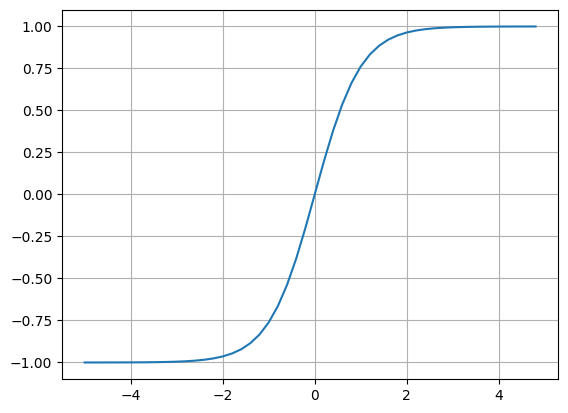

In [89]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

So let's start

# Exercise 1.5

Implement the board's network (2 features, linear combination to "n")

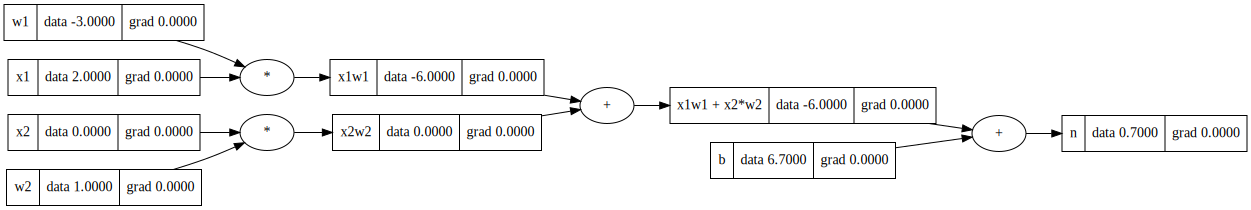

In [95]:


x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

draw_dotV3(n)

What's missing? The `activation function`

In [126]:
try:
    o = n.tanh()
except:
    raise NotImplementedError('Need to implement tanh method in our Value data structure')

NotImplementedError: Need to implement tanh method in our Value data structure

`Exercise`: Let's implement tanh!

In [129]:


class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')

    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')

    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')

    def tanh(self):
        x = self.data
        out = (math.exp(2 * self.data ) -1) /(math.exp(2 * self.data ) +1)
        return Value(out, (self,), 'tanh')


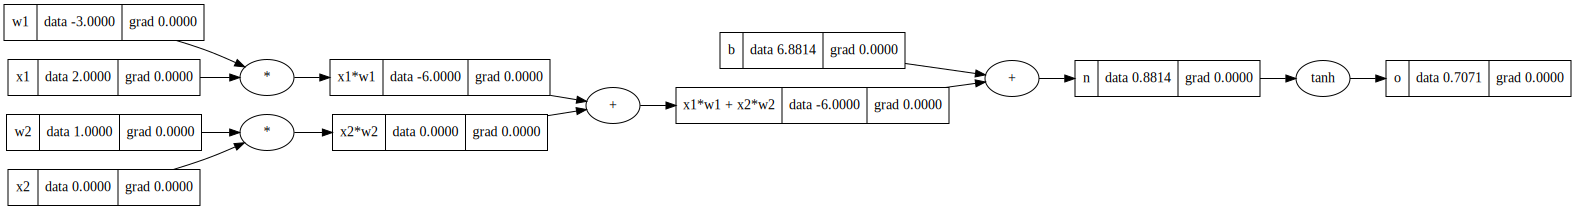

In [130]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!
draw_dotV3(o)

Let's start backpropagation!

In [131]:
o.grad = 1.0

what's the derivative of a tanh wrt. its input?
[wikipedia](https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives)

In [132]:
# Exercise
n.grad = (1 - o.data**2) * o.grad

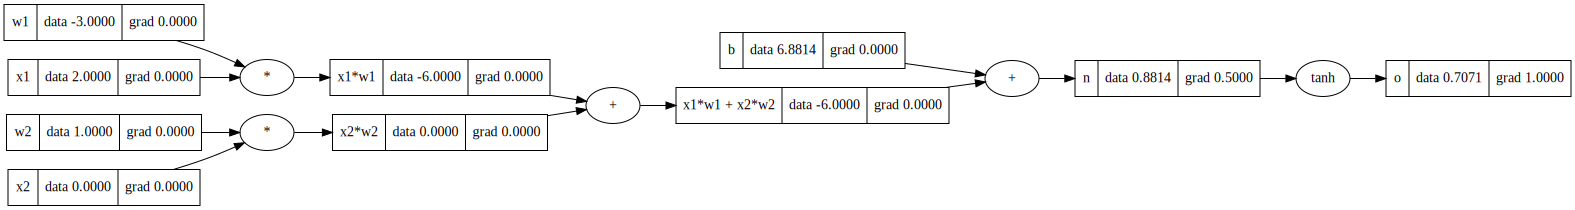

In [133]:
draw_dotV3(o)

In [134]:
# now compute the grads for all the nodes
b.grad = 1.0 * n.grad
x1w1x2w2.grad = 1.0 * n.grad

x1w1.grad = 1.0 * x1w1x2w2.grad
x2w2.grad = 1.0 * x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

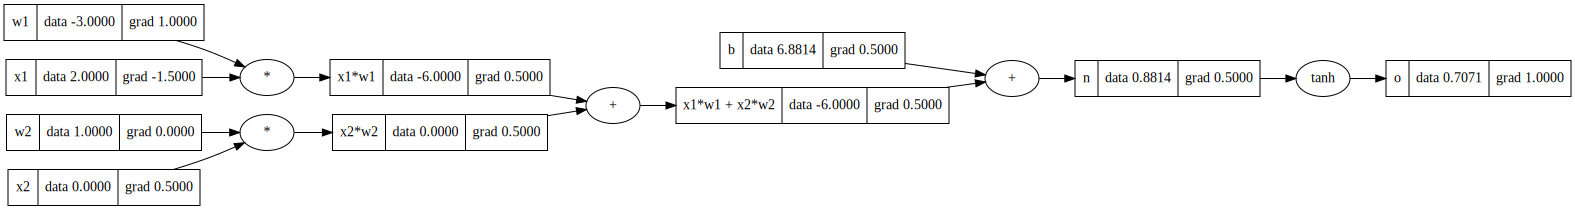

In [135]:
draw_dotV3(o)

----

Okay! We've successfully done backprop manually! Now this is very cumbersome process to do manually so let's add the necessary logic to do this automatically!

`Demonstration`: implement backpropagation for the addition

In [136]:
# needs implementation of backpropagation
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: Value):
        out =  Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other: Value):
        out =  Value(self.data * other.data, (self,other), '*')
        return out

    def __sub__(self, other: Value):
        out = Value(self.data - other.data, (self,other), '-')
        return out

    def __truediv__(self, other: Value):
        out = Value(self.data / other.data, (self,other), '/')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

## Exercise 2: implement backwards for multiplication, sub and division

Go [here](https://colab.research.google.com/github/samsung-ai-course/6-7-edition/blob/main/Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/Exercise%202%20-%20Implement%20remaining%20backward.ipynb) to jump into exercise 2.

![](https://github.com/samsung-ai-course/8th-9th-edition/blob/main/Chapter%206%20-%20Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/media/jump.jpg?raw=1)

In [137]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._backward = lambda: None # this method does the chain rule and stores how it transmits the output's gradient into the inputs' gradient of the current node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: "Value"):
        out =  Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other: "Value"):
        out =  Value(self.data * other.data, (self,other), '*')

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad

        out._backward = _backward
        return out


    def __sub__(self, other: "Value"):
        out = Value(self.data - other.data, (self,other), '-')
        def _backward():
          self.grad += out.grad
          other.grad += -1 * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other: "Value"):
        out = Value(self.data / other.data, (self,other), '/')
        def _backward():
          self.grad += (1/other.data) * out.grad
          other.grad += (-self.data / (other.data **2)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
          self.grad += (1 - out.data **2) * out.grad
        out._backward = _backward
        return out

----

Going back to our logistic regression (now with backpropagation!)

In [138]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!


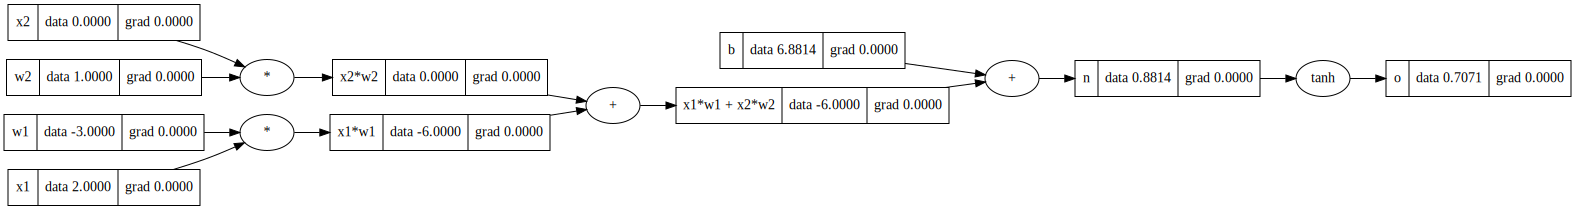

In [139]:
draw_dotV3(o)

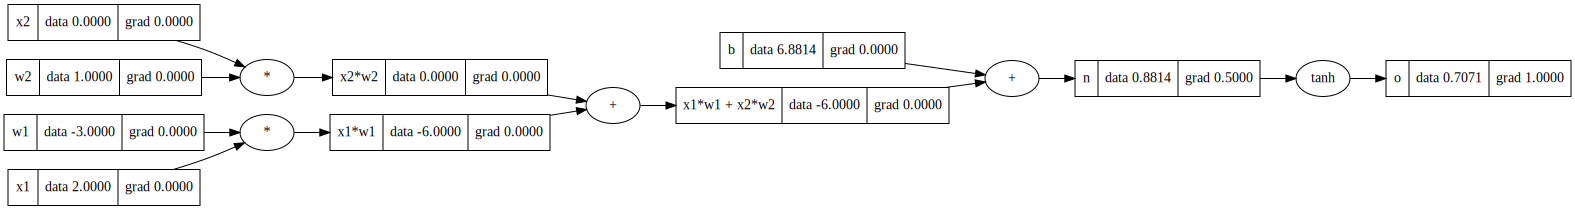

In [140]:
o.grad = 1.0
o._backward()
draw_dotV3(o)

In [141]:
n._backward()
# check draw_dot

In [143]:
b._backward()
# check draw_dot


In [144]:
x1w1x2w2._backward()
# check draw_dot

In [145]:
x1w1._backward()
x2w2._backward()
# check draw_dot

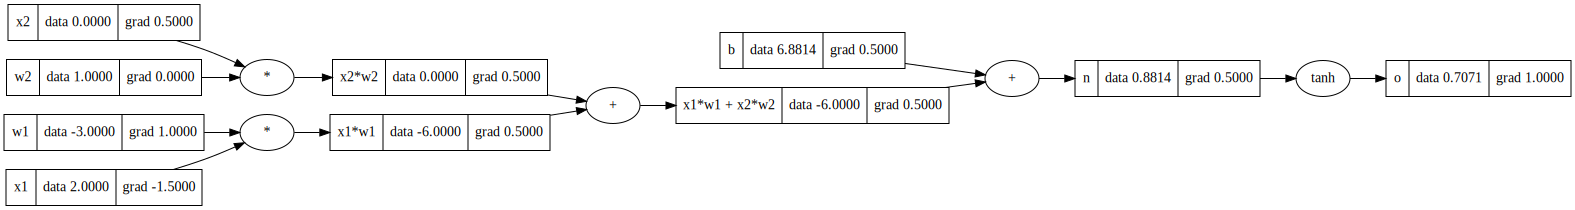

In [146]:
draw_dotV3(o)

----

So let's automate this!

1. We want to call ._backward() from end of the graph to the start. Never call on a node where the parent node hasn't yet been called.


answer: `topological sort!`

In [147]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
print(topo)

[Value(6.881373587019543), Value(0.0), Value(1.0), Value(0.0), Value(2.0), Value(-3.0), Value(-6.0), Value(-6.0), Value(0.8813735870195432), Value(0.7071067811865476)]


Let's reset the gradients and call backward now on this list starting from the `o` node

In [148]:
topo = []
visited = set()
build_topo(o)

o.grad = 1.0
for node in reversed(topo):
    node._backward()

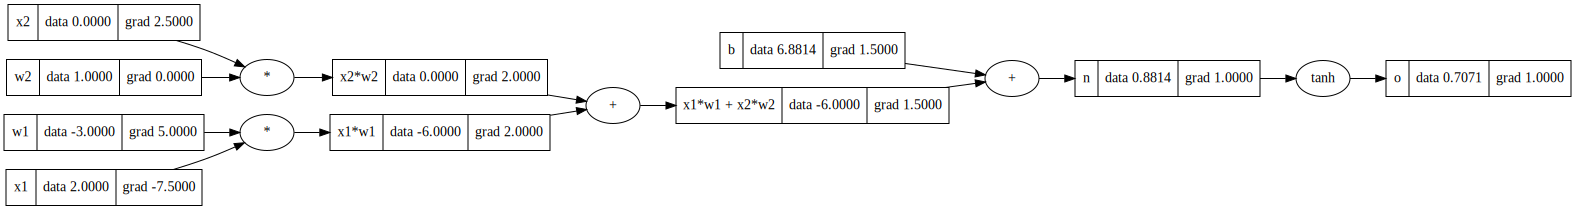

In [149]:
draw_dotV3(o)

Let's hide this functionality

`Demonstration`: implement **backward**

`Bonus:`: \_\_pow\_\_ was implemented & improved input compatibility

In [165]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._backward = lambda: None # this method does the chain rule and stores how it transmits the output's gradient into the inputs' gradient of the current node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # implement backward method
    def backward(self):
      topo = []
      visited = set()

      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
          node._backward()

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self,other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self,other), '/')

        def _backward():
            self.grad += (1.0 / other.data) * out.grad
            other.grad += (-self.data / (other.data**2)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other : int):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out



In [169]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!

In [170]:
o.backward()

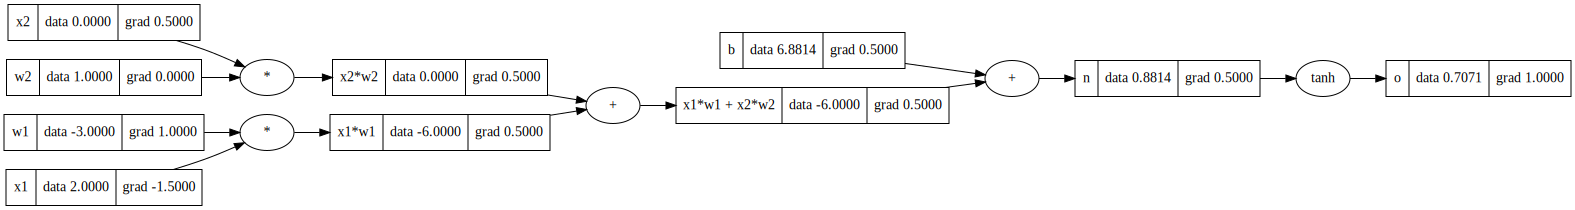

In [171]:
draw_dotV3(o)

![](https://github.com/samsung-ai-course/8th-9th-edition/blob/main/Chapter%206%20-%20Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/media/pika.jpg?raw=1)

## Edge cases: Why do we accumulate gradients?

### Example 1

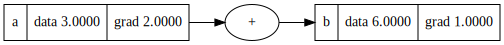

In [172]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dotV3(b)

### Example 2

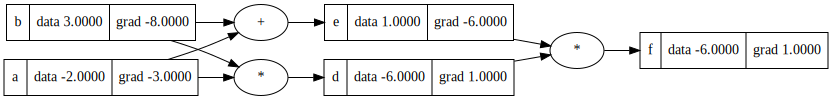

In [163]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dotV3(f)


# Building our Neural Network

In [173]:
class Module:

    def zero_grad(self):
        """
        # we always want to be able to reset the gradients for the next iteration of training
        """
        # what is this for?
        #

    def parameters(self):
        return []

In [178]:
import random

class Neuron(Module):

    def __init__(self, nin: int, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        """
        Computes the activation of the neuron given input x.

        Expects x to be an iterable with the same dimensions as the number of inputs (nin), and weights (w).
        """
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        # now we can return the parameters of this neuron
        return self.w + [self.b]

    def __repr__(self):
        return f"{'tanh' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

x = [2.1, 3.1]
n = Neuron(2)
n(x)


Value(0.39037404752260463)

We want to be able to build a layer of neurons

In [181]:
class Layer(Module):

    def __init__(self, nin : int, nout : int, **kwargs):
        self.neurons = [Neuron(nin, kwargs) for _ in range(nout)]

    def __call__(self, x):
        """
        Computes the output of the layer given input x.

        Expects x to be an iterable with the same dimensions as the number of inputs (nin), and weights (w).
        """
        # Compute the output of the layer given input x
        #...
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [182]:
x = [2.1, 3.1]
n = Layer(2,3)
n(x)

[Value(-0.5179053251098259),
 Value(1.8919783077955212),
 Value(-2.4843186982127827)]

An MLP is a bunch of layers together

In [184]:
from typing import List

class MLP(Module):

    def __init__(self, nin : int, nouts: List[int]):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [185]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [8,4,1])
n(x)

Value(0.8681095203539755)

----

# Can our network learn?

In [186]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [187]:
# input data is 3d so let's choose 3 as input size and do 2 hidden layers
n = MLP(3, [4,4,1])

In [188]:
# let's try to see the initial predictions first
ypred = [n(x) for x in xs]
ypred


[Value(-0.4641357761770935),
 Value(-0.45926700908577417),
 Value(-0.4331193009679678),
 Value(-0.4331231683168157)]

In [190]:
# Mean squared error
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(2.1436935710817),
 Value(0.2923921674630442),
 Value(0.3213537269350455),
 Value(2.053842015566428)]

In [191]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))
loss

Value(4.811281481046217)

In [192]:
loss.backward() # perform backwards pass

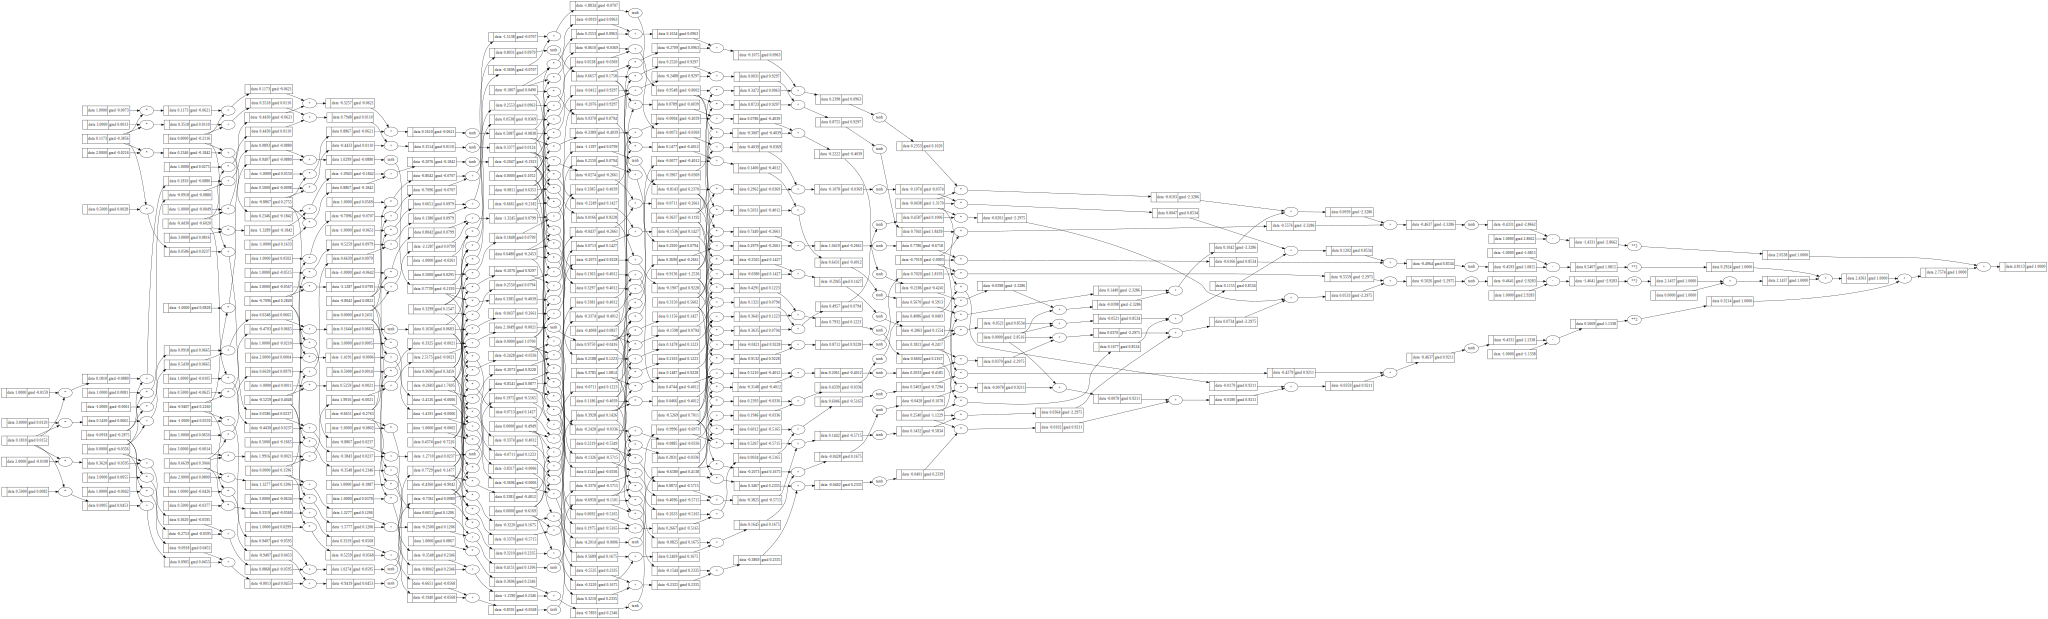

In [193]:
draw_dotV3(loss)

In [194]:
n.layers[0].neurons[0].w[0].grad # this weight is going to update in the opposite direction

0.01520966715029106

Let's update the parameters to reduce the loss!

In [195]:
for p in n.parameters():
    p.data -= 0.01 * p.grad


compute loss again

In [196]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))
loss

Value(4.53391484392091)

It's lower!

Do we want to keep training?

In [197]:
# reset the gradients every iteration! (one of the most common DL silent bugs)

for p in n.parameters():
    p.grad = 0.0

----

We can automate this as well, let's say we want to train for 20 epochs

In [198]:
for epoch in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    # mse loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0 # reset first
    loss.backward()

    # update model parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(epoch, loss.data)

0 4.53391484392091
1 3.348218946538906
2 2.647084796306337
3 1.8913515214795924
4 1.1930576861053697
5 0.7466876064565975
6 0.5030567369939577
7 0.3656143352973869
8 0.28155499070477646
9 0.22621268336179065
10 0.18757184025393517
11 0.15932178200975328
12 0.1379029259084385
13 0.1211812973439654
14 0.10781075940297556
15 0.09690524333275466
16 0.08786023712591803
17 0.08025056445816317
18 0.07376926211146083
19 0.06818963678347757


# Let's try to fit some quadratic function

In [199]:
from sklearn.model_selection import train_test_split

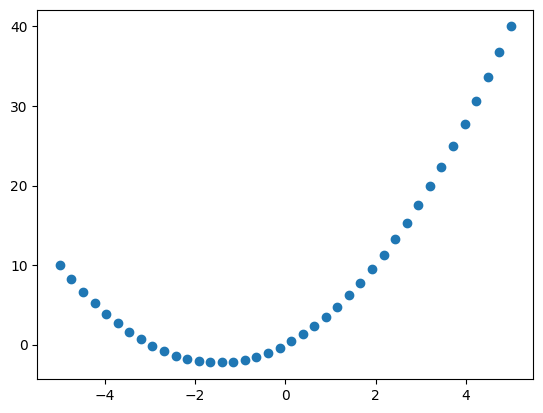

In [200]:
def quadratic_func(x):
    return np.power(x,2) + 3*x

xs = np.linspace(-5,5,40)
ys = quadratic_func(xs)
plt.scatter(xs,ys)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

## Exercise: use an MLP to fit this data

1. Use one hidden layer, but you can decide how many neurons in that layer
2. Plot the loss along the epochs
3. Plot the model's prediction and datapoints along the epochs (to see visually how close it is modelling the data)

----

# Future Work

1. Implement other activations to `Value` such as ReLU and Sigmoid
2. Implement classification capability by having a Sigmoid at the final layer
3. Try this dataset on the Iris dataset. choose 2 classes from there and try to fit that data